Una vez balanceado el dataset en su varaible respuesta y por nacionalidades todavía tenemos un dataset de casi 80K casos. Se ha analizado cuál sería el tamaño optimo para modelizar.

Se han probado 3 modelos distintos con una minima restriccion de profundidad para los modelos basados en arboles. Vemos que el accuracy de los modelos aumenta siempre a mayor numero de casos pero parece estabilizarse y crecer muy lentamente a partir de los 50K casos aproximadamente.

### Open File

In [42]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
%matplotlib notebook

In [43]:
df = pd.read_csv('./data/df_features.gz')

### Create Predicted Category for final models (2 categories)

In [44]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [45]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [46]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df) 

Good    0.831599
Bad     0.168401
Name: Category, dtype: float64

### Balance Categories

In [47]:
def balance_df(df, Balance_Nationality, Balance_Category, cut):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = cut
            if len(nationality) < n:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [48]:
df_balanced_1 = balance_df(df, Balance_Nationality=False, Balance_Category=True, cut=10000)
df_balanced_2 = balance_df(df_balanced_1, Balance_Nationality=True, Balance_Category=True, 
                         cut=int(np.median(df_balanced_1.Nationality_Recode.value_counts())*1.5))
df_balanced_2.shape

(77270, 78)

### Prepare Data to run Models

In [49]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','Price','Reservation_ADR',
               'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [50]:
X_numerical = df_balanced_2[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [51]:
X_categorical = pd.get_dummies(df_balanced_2[x_categorical], prefix_sep='_', drop_first = True)
X_categorical = X_categorical.fillna('Not Available')

In [52]:
X = pd.concat([X_numerical_std, X_categorical], axis = 1, sort = False)
y = df_balanced_2[y_col]

In [53]:
X.shape, y.shape

((77270, 69), (77270,))

## MODELS

In [54]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [55]:
def evaluate(size, model):
    clf = model
    clf.fit(X_train, y_train)
    train = clf.predict(X_train)
    pred = clf.predict(X_test)
    return(accuracy_score(pred, y_test))

In [79]:
from sklearn.model_selection import train_test_split
import random

n = 0
sizes = [1000, 2500, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 75000]
universe = list(X.index)
models = [DecisionTreeClassifier(max_depth=5, random_state=1), 
          LogisticRegression(max_iter=1000, random_state=1),
          RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state=1)]

acc_mean = []
for model in models:
    accuracies = []
    for i in range(25):
        tmp = []
        for size in sizes:
            sample = random.sample(universe, size)
            X_size = X.loc[sample, :]
            y_size = y[sample]
            X_train, X_test, y_train, y_test = train_test_split(X_size, y_size, test_size=0.8, random_state=100)
            tmp.append(evaluate(size, model))
            n = n+1
            print(f'{(100*n)/(len(sizes)*len(models)*25):.2f}', end='\r', flush=True)
        accuracies.append(tmp)
    acc_mean.append(np.mean(accuracies, axis=0)) 

<IPython.core.display.Javascript object>


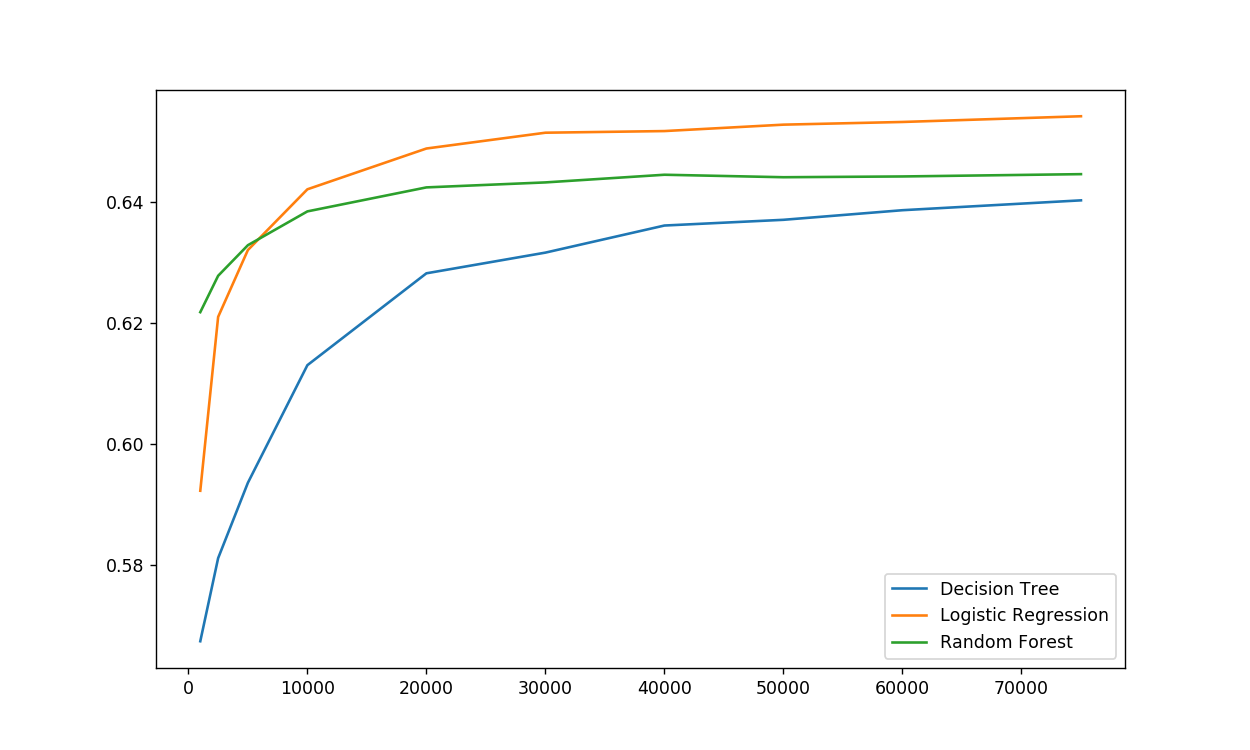

In [80]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sizes, acc_mean[0], label = 'Decision Tree')
ax.plot(sizes, acc_mean[1], label = 'Logistic Regression')
ax.plot(sizes, acc_mean[2], label = 'Random Forest')
ax.legend()

In [81]:
pd.DataFrame(acc_mean, columns = sizes, index=['DT','LR','RF'])

,1000,2500,5000,10000,20000,30000,40000,50000,60000,75000
DT,0.56735,0.58110,0.59357,0.613030,0.628230,0.631653,0.636135,0.637082,0.638671,0.640302
LR,0.59225,0.62102,0.63208,0.642130,0.648878,0.651493,0.651765,0.652826,0.653271,0.654217
RF,0.62180,0.62782,0.63288,0.638475,0.642445,0.643270,0.644539,0.644127,0.644255,0.644637
